[*********************100%***********************]  1 of 1 completed


🔍 Model Performance:
RandomForest Accuracy: 0.40


C:\Users\ersan\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:15:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.44
SVM Accuracy: 0.54
LogisticRegression Accuracy: 0.45

✅ Final Model Evaluation:
Accuracy: 0.54
              precision    recall  f1-score   support

           0       0.42      0.17      0.24       106
           1       0.57      0.82      0.67       141

    accuracy                           0.54       247
   macro avg       0.49      0.50      0.46       247
weighted avg       0.50      0.54      0.49       247



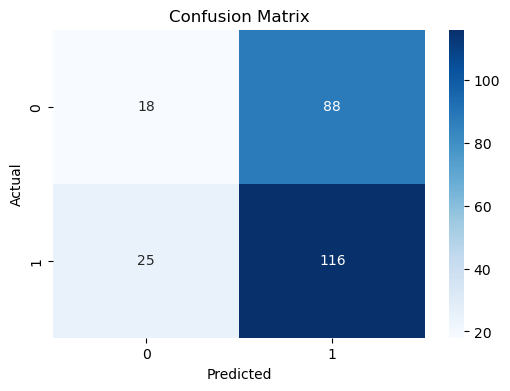

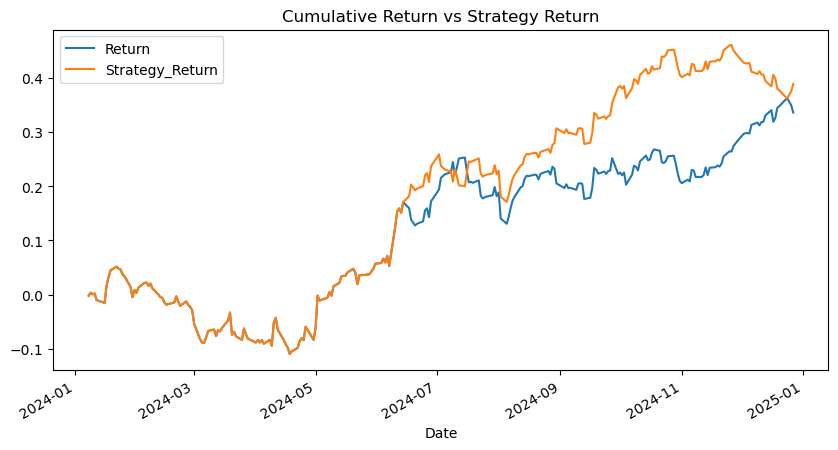


📈 Live AAPL Price: $202.14
🤖 Bot decision: SHORT (Price is expected to go DOWN)


In [7]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import ta
import requests
from dotenv import load_dotenv

# Load API keys from .env
load_dotenv()
FINNHUB_API_KEY = os.getenv("FINNHUB_API_KEY")

# Finnhub config
FINNHUB_URL = "https://finnhub.io/api/v1/quote"
symbol = "AAPL"

# 1. Download historical data
data = yf.download(symbol, start="2020-01-01", end="2024-12-31")
data = data[['Close']].copy()  # Ensure this is a Series and not a DataFrame
data['Close'] = data['Close'].astype(float)  # Make sure Close is in float format
data['Return'] = data['Close'].pct_change()
data['Target'] = (data['Return'].shift(-1) > 0).astype(int)
data = data.dropna()

# 2. Technical indicators
data['MA5'] = data['Close'].rolling(window=5).mean()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['Volatility'] = data['Return'].rolling(window=5).std()

# Fix: Use squeeze() to ensure 'Close' is a Series
data['RSI'] = ta.momentum.RSIIndicator(close=data['Close'].squeeze(), window=14).rsi()
data['MACD'] = ta.trend.MACD(close=data['Close'].squeeze()).macd()  # Fixed line
bb = ta.volatility.BollingerBands(close=data['Close'].squeeze())  # Apply squeeze here
data['BB_Upper'] = bb.bollinger_hband()
data['BB_Lower'] = bb.bollinger_lband()
data = data.dropna()

# 3. Features and target
features = ['MA5', 'MA10', 'Volatility', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']
X = data[features]
y = data['Target']

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 5. Try multiple models
models = {
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(max_iter=1000)
}

best_model = None
best_score = 0

print("🔍 Model Performance:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.2f}")
    if acc > best_score:
        best_score = acc
        best_model = model

# 6. Final evaluation
y_pred = best_model.predict(X_test)
print("\n✅ Final Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# 7. Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 8. Simulate returns
signals = pd.DataFrame(index=y_test.index)
signals['Prediction'] = y_pred
signals['Price'] = data.loc[y_test.index, 'Close']
signals['Next_Day_Price'] = signals['Price'].shift(-1)
signals['Return'] = signals['Next_Day_Price'] / signals['Price'] - 1
signals['Strategy_Return'] = signals['Return'] * (signals['Prediction'] * 2 - 1)
signals[['Return', 'Strategy_Return']].cumsum().plot(figsize=(10, 5))
plt.title('Cumulative Return vs Strategy Return')
plt.show()

# 9. Live prediction using Finnhub price
latest = X.iloc[-1:]
prediction = best_model.predict(latest)[0]

try:
    response = requests.get(FINNHUB_URL, params={'symbol': symbol, 'token': FINNHUB_API_KEY})
    quote = response.json()
    current_price = quote['c']
    print(f"\n📈 Live AAPL Price: ${current_price:.2f}")
except Exception as e:
    print("⚠️ Error getting live price from Finnhub:", e)
    current_price = None

if prediction == 1:
    print("🤖 Bot decision: LONG (Price is expected to go UP)")
else:
    print("🤖 Bot decision: SHORT (Price is expected to go DOWN)")